# Hyperparameter Tuning using Keras Tuner - 2

In this notebook, we will explore the Keras Tuner library, a powerful tool designed to streamline the hyperparameter tuning process for your TensorFlow models. Hyperparameters are critical variables that influence both the model's architecture and its training process. Selecting the right hyperparameters can significantly enhance model performance and ensure efficient training.

Hyperparameters can be broadly classified into two categories:

- Model Hyperparameters: These parameters define the architecture of the model, such as the number of hidden layers, the number of units within each layer, and the activation functions used.
- Algorithm Hyperparameters: These parameters influence the efficiency and efficacy of the training algorithm, such as the learning rate for optimization algorithms like Stochastic Gradient Descent (SGD).

To effectively tune these hyperparameters, we will define a hypermodel, which includes both the model architecture and the hyperparameter search space. This can be achieved through two main approaches:

- Model Builder Function: A function that directly constructs the model and incorporates hyperparameters.
- Subclassing the HyperModel Class: This method offers greater flexibility and organization, especially when working with complex models.


### Hypermodel
For this tutorial, we will **subclass the HyperModel class** from the Keras Tuner API to create a customized classification model, allowing us to define specific hyperparameters and their search spaces. Within this subclass, we will implement the build and fit methods to specify the hyperparameters we wish to tune, including learning rate, batch size, and the number of epochs.


### Tuner
After defining our hypermodel, we will instantiate a tuner to perform the hyperparameter search. **Keras Tuner offers several tuning strategies, including RandomSearch, Hyperband, Bayesian Optimization, and Sklearn-based tuners**. In this tutorial, we will focus on **Hyperband**.

- RandomSearch: This tuner explores a random selection of hyperparameter combinations within the defined search space. It is simple and efficient for relatively smaller search spaces, but as the number of hyperparameters increases, the randomness may miss potentially better combinations.

- Hyperband: This is a more advanced strategy, designed to accelerate hyperparameter optimization by focusing computational resources on the most promising configurations. It initially tests many hyperparameter combinations with fewer epochs and gradually allocates more resources to those performing better. This strategy allows Hyperband to balance exploration and exploitation, making it faster and more efficient for large hyperparameter spaces compared to RandomSearch.

##### When to Use Hyperband vs. Random Search:
- Use Hyperband when you have limited time or computational resources and a large hyperparameter search space. Hyperband excels in quickly identifying promising configurations by pruning less optimal ones.

- Use Random Search if you want to explore the entire search space equally or have enough resources to evaluate all configurations for a full training cycle.


### Demo: Hyperband
For this demonstration, we will address a multi-class classification problem using a single-layer neural network, commonly referred to as a Linear Neural Network (LNN). This model will be configured to perform softmax regression to classify the **MNIST dataset**, which consists of images of handwritten digits. We will utilize the **Hyperband** tuner to optimize three key hyperparameters: **the learning rate, the number of epochs, and the batch size**. Our objective is to maximize the validation accuracy, ensuring that our model generalizes well to unseen data.

#### Hyperband
Hyperband is a hyperparameter optimization algorithm designed to quickly and efficiently find the best model hyperparameters. It works by combining random search with early stopping techniques to focus on the most promising hyperparameter configurations. Here's how Hyperband functions:

- Resource Allocation: Hyperband allocates a specific budget (such as the number of epochs or iterations) to a set of random hyperparameter configurations.

- Early Stopping: Instead of running each configuration for the entire budget, Hyperband starts with many configurations but runs them for a smaller number of iterations. It then stops (or "prunes") poorly performing configurations early, reallocating resources to the more promising ones.

- Successive Halving: This process of removing less promising configurations while increasing the resources (e.g., epochs) allocated to the better-performing ones is called successive halving. Hyperband repeatedly doubles the resources for the best-performing models, refining them over time.

- Efficiency: By focusing resources on the more promising candidates early in the search process, Hyperband reduces the overall time spent training less useful models.

To get started with hyperparameter tuning using Keras Tuner, ensure you have the library installed by running the following command: 

        pip install keras-tuner --upgrade

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
import keras_tuner as kt

## Multiclass Dataset


We use the MNIST (Modified National Institute of Standards and Technology) dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.


There are 70,000 images. Each image is **grayscale 28 x 28 pixels**, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Thus, each image has **784 features**. 

The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.


In [2]:
# Load data 
mnist = fetch_openml('mnist_784', parser='auto', cache=False)

# Create feature matrix and target array; then typecast
X = mnist["data"].astype('float32')
y = mnist["target"].astype('int64')


print("\nNo. of Samples: ", X.shape)
print("No. of Labels: ", y.shape)


No. of Samples:  (70000, 784)
No. of Labels:  (70000,)


## Scale the Dataset

In [3]:
X /= 255.0

## Create Train, Test, and Validation Subsets

In [4]:
# Create training and test subsets from the full dataset
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create train and validation subsets from the training set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=0)

print("\nShape of Training Samples: ", X_train.shape)
print("Shape of Training Labels: ", y_train.shape)

print("\nShape of Validation Samples: ", X_valid.shape)
print("Shape of Validation Labels: ", y_valid.shape)

print("\nShape of Testing Samples: ", X_test.shape)
print("Shape of Testing Labels: ", y_test.shape)


Shape of Training Samples:  (44800, 784)
Shape of Training Labels:  (44800,)

Shape of Validation Samples:  (11200, 784)
Shape of Validation Labels:  (11200,)

Shape of Testing Samples:  (14000, 784)
Shape of Testing Labels:  (14000,)


## Hyperparameter Tuning using the Hyperband Tuner


In [5]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise, memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)



# Define a custom hypermodel by subclassing the HyperModel class from Keras Tuner
class CustomHyperModel(kt.HyperModel):

    '''
    Initialize the CustomHyperModel instance.

    Parameters:
    - number_of_classes: int
        The total number of output classes for the classification task. 
        This determines the number of units in the output layer of the model.
    
    - regularizer: tf.keras.regularizers.Regularizer or None
        A regularization technique to apply to the model's weights, helping to 
        prevent overfitting. If set to None, no regularization is applied.
    
    The initialized attributes can be accessed in other methods of the class,
    such as 'build' for constructing the model architecture.
    '''

    def __init__(self, model_name, number_of_features, number_of_classes, regularizer, **kwargs):
        self.number_of_classes = number_of_classes  # Store number of classes
        self.regularizer = regularizer  # Store regularizer

    
    # Method to build the model architecture
    def build(self, hp):
        # Initialize a sequential model for multiclass classification
        model = tf.keras.models.Sequential(name=model_name)
        
        # Input layer: Specify the shape of the input data (4 features)
        model.add(tf.keras.layers.Input(shape=[number_of_features,]))  
        
        # Output layer: A dense layer with softmax activation for multiclass classification
        # The number of output units corresponds to the number of classes
        model.add(tf.keras.layers.Dense(units=number_of_classes, 
                                        kernel_initializer="zeros",
                                        kernel_regularizer=regularizer,
                                        activation="softmax"))
        
        # Compile the model with a stochastic gradient descent (SGD) optimizer
        # The learning rate is a hyperparameter to tune, sampled from a logarithmic range
        model.compile(
            optimizer=tf.keras.optimizers.SGD(
                learning_rate=hp.Float('learning_rate', 
                                       min_value=0.01, max_value=0.5, sampling='log')),
            loss='sparse_categorical_crossentropy',  # Loss function for multiclass classification
            metrics=['accuracy']  # Metric to evaluate during training
        )
        return model  # Return the compiled model

    # Method to fit the model to the training data
    def fit(self, hp, model, *args, **kwargs):
        # Remove 'epochs' from kwargs to avoid conflict
        if 'epochs' in kwargs:
            kwargs.pop('epochs')
            
        return model.fit(
            *args,  # Pass other arguments to the fit method
            # Tune the number of epochs as a hyperparameter within a specified range
            epochs=hp.Int("epochs", min_value=10, max_value=60, step=20),
            # Tune the batch size from a predefined set of options
            batch_size=hp.Choice("batch_size", [16, 32, 64]),
            **kwargs,  # Pass any additional keyword arguments
        )


# Initialize the model variables
model_name = "LNN_MNIST_Tuning"
number_of_features = 784
number_of_classes = 10
# Declare and initialize the weight-based regularizer variable
# To disable weight-based regularization, set this variable to None
regularizer = None
#tf.keras.regularizers.L2(l2=0.0001)
#regularizer = tf.keras.regularizers.L2(l2=0.0001)

# Instantiate the Hyperband tuner from Keras Tuner
tuner = kt.Hyperband(
    CustomHyperModel(model_name, number_of_features, number_of_classes, regularizer),  # Specify the hypermodel to be tuned
    objective='val_accuracy',  # The objective to optimize (validation accuracy)
    max_epochs=60,  # Maximum number of epochs to run
    factor=3,  # Factor by which the resources (epochs) are reduced at each bracket step
    executions_per_trial=1,  # Number of executions (repeats) per trial
    directory='my_dir',  # Directory where results will be saved
    project_name='tuning_hypermodel',  # Name of the project
    overwrite=True  # Overwrite existing results if they exist
)

# Begin the hyperparameter search process
tuner.search(X_train, y_train,  # Training data and labels
             validation_data=(X_valid, y_valid),  # Validation data for evaluation
             verbose=1)  # Verbosity level for output messages

# Retrieve the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Get the best hyperparameters identified during the search
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters for review
print(f"Best learning rate: {best_hp.get('learning_rate')}")
print(f"Best batch size: {best_hp.get('batch_size')}")
print(f"Best epochs: {best_hp.get('epochs')}")
print("\n")

Trial 90 Complete [00h 00m 08s]
val_accuracy: 0.9206249713897705

Best val_accuracy So Far: 0.9257143139839172
Total elapsed time: 00h 26m 38s
Best learning rate: 0.015677501977560605
Best batch size: 16
Best epochs: 50


CPU times: user 32min 32s, sys: 7min 38s, total: 40min 11s
Wall time: 26min 38s


## Build the Model with Optimal Hyperparameters

In [6]:
# Build the model with optimal hyperparameters 
model = tuner.hypermodel.build(best_hp)

# Display a detailed summary of the model
model.summary() 

Model: "LNN_MNIST_Tuning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## Train the Model with Optimal Hyperparameters
Some hyperparameters need to be set within the fit method, such as epochs and batch size.

In [7]:
%%time

'''
Declare and initialize the early stopping callback function
- It will monitor validation loss and stop training if there are no improvements for 10 consecutive epochs
- With restore_best_weights set to True, the model will revert to the weights from the epoch 
where the validation loss (or other monitored metric) was at its minimum.
- With min_delta set to 0, any improvement in the monitored metric (such as validation loss) will be considered as progress.
  -- If min_delta=0, the early stopping callback will consider even the smallest change (positive or negative) 
     in the monitored metric as an improvement.
  -- If min_delta is set to a positive value, say min_delta=0.01, the model will only consider 
     a change greater than 0.01 in the monitored metric as an improvement, ignoring smaller variations.
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

# Fit the model on the training data with the best epochs and batch size
history = model.fit(
    X_train,
    y_train,
    epochs=best_hp.get('epochs'),  # Use the best number of epochs
    batch_size=best_hp.get('batch_size'),  # Use the best batch size
    validation_data=(X_valid, y_valid), 
    callbacks=[early_stopping_cb], # Early stopping callback function
    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 
)

Epoch 1/50
2800/2800 [==============================] - 1s 267us/step - loss: 0.5765 - accuracy: 0.8642 - val_loss: 0.3993 - val_accuracy: 0.8938
Epoch 2/50
2800/2800 [==============================] - 1s 248us/step - loss: 0.3729 - accuracy: 0.8989 - val_loss: 0.3509 - val_accuracy: 0.9032
Epoch 3/50
2800/2800 [==============================] - 1s 255us/step - loss: 0.3406 - accuracy: 0.9064 - val_loss: 0.3307 - val_accuracy: 0.9078
Epoch 4/50
2800/2800 [==============================] - 1s 245us/step - loss: 0.3238 - accuracy: 0.9101 - val_loss: 0.3182 - val_accuracy: 0.9116
Epoch 5/50
2800/2800 [==============================] - 1s 241us/step - loss: 0.3129 - accuracy: 0.9134 - val_loss: 0.3107 - val_accuracy: 0.9151
Epoch 6/50
2800/2800 [==============================] - 1s 241us/step - loss: 0.3049 - accuracy: 0.9158 - val_loss: 0.3041 - val_accuracy: 0.9152
Epoch 7/50
2800/2800 [==============================] - 1s 241us/step - loss: 0.2990 - accuracy: 0.9176 - val_loss: 0.3009 -

## Learning Curve


A learning curve is a graphical representation that shows the relationship between a model’s performance (often measured by metrics like accuracy, loss, or error) and the amount of training data or iterations (epochs).

In the context of machine learning, the learning curve typically tracks two main aspects:

- Training Performance: The model's performance on the training data over time.
- Validation/Test Performance: The model's performance on unseen validation or test data over time.

Key Insights from a Learning Curve:
- Convergence: When both training and validation curves flatten, the model has likely converged.
- Overfitting: If the training performance is good but the validation performance is poor, the model is overfitting.
- Underfitting: If both the training and validation performance are poor, the model may be underfitting.




## A Function For Generating Learning Curves (Accuracy & Loss)

In [8]:
def plot_learning_curves(history, numOfEpochs, title):
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation', color="r")
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training', color="b")
    plt.legend(loc=0, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation', color="r")
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training', color="b")
    plt.legend(loc=0, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 

Epochs:  50


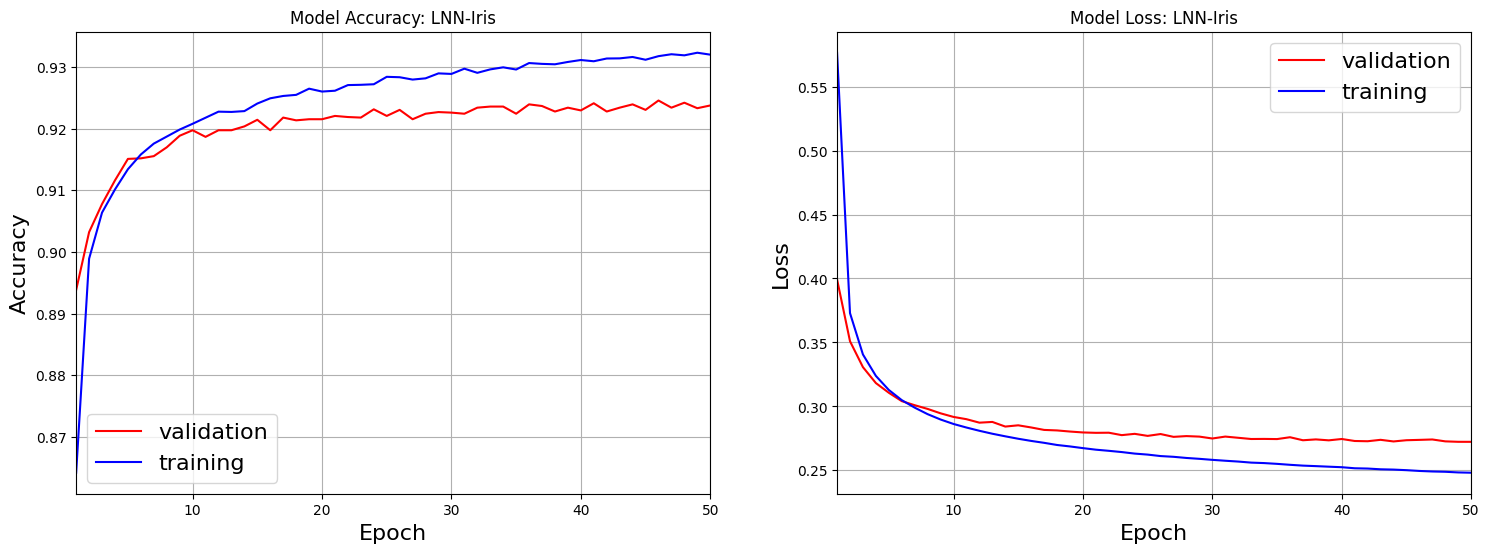

In [9]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

plot_learning_curves(history, numOfEpochs, "LNN-Iris")

## Evaluate the LNN Model

In [10]:
print("Epochs: ", numOfEpochs)

# Display train and test performance metrics (accuracy and loss)
print("\nTrain Data: Loss & Accuracy: ", model.evaluate(X_train, y_train, verbose=0))
print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))


'''
Compute the train accuracy
'''
# The model.predict() method returns 3 probabilities per class for each instance (Dimension Nx3)
y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)

'''
Compute the test accuracy
'''
# The model.predict() method returns 3 probabilities per class for each instance (Dimension Nx3)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class
test_accuracy = np.mean(y_test_predicted == y_test)



print("\nTrain Accuracy: ", train_accuracy)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  50

Train Data: Loss & Accuracy:  [0.245264932513237, 0.9331473112106323]

Test Data: Loss & Accuracy:  [0.2920948266983032, 0.9177857041358948]
438/438 [==============================] - 0s 184us/step

Train Accuracy:  0.9331473214285714

Test Accuracy:  0.9177857142857143

Test Confusion Matrix:
[[1338    0    3    6    3   15   14    1    7    0]
 [   0 1540    9    3    2    5    1    2   16    2]
 [   6   15 1299   22   24    3   12   16   39    7]
 [   5    6   47 1278    0   39    2   13   29   16]
 [   1    3    7    1 1266    2   15   10    5   40]
 [  11    6   14   50   15 1057   24    8   35   11]
 [  13    5   15    1   16   14 1311    2   10    0]
 [   4    6   21    5   11    3    1 1348    6   53]
 [   5   32   11   32   10   37   11    3 1210   17]
 [   5    4    6   20   58   10    1   45   10 1202]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1387
           1       0.95